In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys 
sys.path.append('..')

from cybb_mist.path_conf import interim_data_dir, processed_data_dir
from tqdm.auto import tqdm
import pandas as pd 
from functional import seq
from cybb_mist.trigger_mapping import parse_trigger_series
from cybb_mist.ecg_processing import process_ecg, ecg_pipeline

## Extracting the HR to the interim folder

In [3]:
# First, process the aligned EDF files
for pqt in tqdm(list(interim_data_dir.rglob("*/ECG_*.parquet"))):
    try:
        print(pqt)
        condition = pqt.name.split('.')[0].split('_')[1]

        # Read & process the ECG file
        df_ecg = pd.read_parquet(pqt)

        df_trigger = parse_trigger_series(
            pd.read_parquet(
                pqt.parent.joinpath(f"SCL_{'_'.join(pqt.name.split('_')[1:])}")
            )["trigger"]
        )
        start, end = df_trigger.t_start.iloc[0], df_trigger.t_start.iloc[-1]
        # df_rr = ecg_pipeline.process(df_ecg['ECG'][start:end], return_df=False)
        df_rr = process_ecg(df_ecg["ECG"][start:end])

        # Save the processed file in feat stat dir
        ecg_feat_stat_dir_user = processed_data_dir.joinpath(pqt.parent.name)
        if not ecg_feat_stat_dir_user.exists():
            os.makedirs(ecg_feat_stat_dir_user)
        df_rr.to_parquet(ecg_feat_stat_dir_user.joinpath(f'df_rr_{condition}.parquet'))
    except Exception as e:
        print(e)


  0%|          | 0/124 [00:00<?, ?it/s]

/users/jonvdrdo/jonas/data/cyberball/interim/4/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/4/ECG_mist.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/45/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/45/ECG_mist.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/63/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/17/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/17/ECG_mist.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/54/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/54/ECG_mist.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/69/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/34/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/34/ECG_mist.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/53/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/53/ECG_mist.parquet
/users/jonvdrdo/jonas/data/cyberball/interim/22/ECG_cybb.parquet
/users/jonvdrdo/jonas/data/

In [ ]:
df_rr.iloc[800:900]

## Toying with the algo's

In [20]:
r_peak_sig_names = (
    seq(df_rr)
    .filter(lambda x: "r_peaks" in x.name.lower() and "processed" not in x.name.lower())
    .map(lambda x: x.name)
    .to_list()
)

In [21]:
valid_rpeak_s = seq(df_rr).filter(lambda x: x.name in r_peak_sig_names).to_list()

In [22]:
from cybb_mist.dataframes import time_based_outer_merge

In [23]:
df_m = None
for s in valid_rpeak_s:
    # s = s.copy()
    # s.loc[:] = 1
    # s_idx = s.index.to_series().rename(s.name)
    if len(s) == 0:
        continue

    if df_m is None:
        df_m = s.to_frame()
    else:
        df_m = time_based_outer_merge(
            df_m, s, tolerance=pd.Timedelta(f"{int(1000 / 200 * 5)}ms")
        )
df_m["r_peak_agreement"] = df_m.notna().sum(axis=1) / len(valid_rpeak_s)

<AxesSubplot:xlabel='timestamp'>

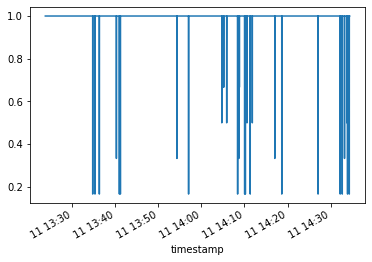

In [24]:
df_m['r_peak_agreement'].plot()

In [10]:
df_m

,ECG_R_Peaks_ECG_neurokit,ECG_R_Peaks_ECG_cleaned_biosppy_martinez,ECG_R_Peaks_ECG_cleaned_biosppy_neurokit,ECG_R_Peaks_ECG_scipy_200Hz_cleaned_biosppy_neurokit,ECG_R_Peaks_ECG_scipy_500Hz_martinez,ECG_R_Peaks_ECG_scipy_500Hz_cleaned_biosppy_martinez,r_peak_agreement
timestamp,,,,,,,
2021-03-11 13:06:10.759000+01:00,NaN,NaN,0.002003,0.001954,NaN,NaN,0.333333
2021-03-11 13:06:16.776000+01:00,NaN,NaN,NaN,0.001776,NaN,NaN,0.166667
2021-03-11 13:06:16.807000+01:00,NaN,NaN,0.002094,NaN,NaN,NaN,0.166667
2021-03-11 13:06:20.644000+01:00,NaN,NaN,0.001896,0.001839,NaN,NaN,0.333333
2021-03-11 13:06:26.850000+01:00,NaN,NaN,0.001818,0.001790,NaN,NaN,0.333333
...,...,...,...,...,...,...,...
2021-03-11 14:45:14.786000+01:00,NaN,NaN,0.001982,NaN,NaN,NaN,0.166667
2021-03-11 14:45:19.058000+01:00,NaN,NaN,0.001891,0.001875,NaN,NaN,0.333333
2021-03-11 14:45:28.164000+01:00,NaN,NaN,0.002091,0.002043,NaN,NaN,0.333333


In [12]:
df_m['r_peak_agreement']

timestamp
2021-03-11 13:06:10.758000+01:00    0.1
2021-03-11 13:06:16.806000+01:00    0.1
2021-03-11 13:06:20.644000+01:00    0.1
2021-03-11 13:06:26.850000+01:00    0.1
2021-03-11 13:06:36.442000+01:00    0.1
                                   ... 
2021-03-11 14:45:14.786000+01:00    0.1
2021-03-11 14:45:19.056000+01:00    0.1
2021-03-11 14:45:28.164000+01:00    0.1
2021-03-11 14:45:44.130000+01:00    0.1
2021-03-11 14:45:44.830000+01:00    0.1
Name: r_peak_agreement, Length: 5528, dtype: float64

In [ ]:
df_m["r_peak_agreement"].shape

In [ ]:
seq(df_rr).filter(lambda x: 'ECG_R_Peaks_processed' == x.name).to_list()[0]

In [ ]:
df_m['r_peak_agreement']

In [ ]:
seq(df_rr).filter(lambda x: 'r_peak_agreement' == x.name).to_list()[0]

In [ ]:
df_m

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
fig = go.Figure(make_subplots(rows=df_rr.shape[1], shared_xaxes=True))
for i, c in enumerate(df_rr.columns, 1):
    fig.add_trace(go.Scattergl(x=df_rr.index, y=df_rr[c], name=c), row=i, col=1)
fig

In [ ]:
df_rr[['ECG', 'r_peak_agreement', 'ECG_R_Peaks_processed']].info()

In [ ]:
df_rr.columns